# Bootstrapping model fits
The previous section describes fitting a single model.
But we may also want to have confidence estimates for the fit.
We can do that via bootstrapping the data set.

Note however that our current recommendation is to use experimental replicates (see later example on *Averaging models*) rather than bootstrapping whenever possible, as experimental replicates often provide more robust senses of error/variation than just boostrapping a single data set.

The overall recommended workflow is to first fit models to all the data to determine the number of epitopes, etc.
Then once the desired fitting parameters are determined, you can bootstrap to get confidence on predictions.

## Get model fit to the data
The first step is just to fit a `Polyclonal` model to all the data we are using.
We do similar to the previous notebook for our RBD example, but first shrink the size of the data set to just 10,000 variants to provide more "error" to better illustrate the bootstrapping.

We will call this model fit to all the data we are using the "root" model as it's used as the starting point (root) for the subsequent bootstrapping.
Note that data (which we will bootstrap) are attached to this pre-fit model:

In [1]:
# NBVAL_IGNORE_OUTPUT

import numpy

import pandas as pd

from plotnine import *

import polyclonal

# read data
noisy_data = (
    pd.read_csv("RBD_variants_escape_noisy.csv", na_filter=None)
    .query('library == "avg3muts"')
    .query("concentration in [0.25, 1, 4]")
)

# just keep some variants to make fitting "noisier"
n_keep = 10000
barcodes_to_keep = (
    noisy_data["barcode"].drop_duplicates().sample(n_keep, random_state=1).tolist()
)
noisy_data = noisy_data.query("barcode in @barcodes_to_keep")

# make and fit the root Polyclonal object with all the data we are using
root_poly = polyclonal.Polyclonal(
    data_to_fit=noisy_data,
    activity_wt_df=pd.DataFrame.from_records(
        [
            ("class 1", 1.0),
            ("class 2", 3.0),
            ("class 3", 2.0),
        ],
        columns=["epitope", "activity"],
    ),
    site_escape_df=pd.DataFrame.from_records(
        [
            ("class 1", 417, 10.0),
            ("class 2", 484, 10.0),
            ("class 3", 444, 10.0),
        ],
        columns=["epitope", "site", "escape"],
    ),
    data_mut_escape_overlap="fill_to_data",
)

opt_res = root_poly.fit(logfreq=200)

# First fitting site-level model.
# Starting optimization of 522 parameters at Sat Aug 27 07:58:15 2022.
         step     time_sec         loss     fit_loss   reg_escape   reg_spread reg_activity
            0      0.12445       5985.7       5979.4      0.59403            0       5.7092
          200       20.551       706.92       691.59       9.9348            0       5.3903
          400       38.615       698.76       682.43       10.938            0       5.3926
          600       54.942       696.57       679.19       11.983            0       5.3954
          800       71.685       695.22       677.36       12.413            0       5.4444
         1000       85.989       694.56       676.54       12.579            0       5.4376
         1200       100.54       694.41       676.01       12.955            0       5.4411
         1400       122.35       693.98       675.24       13.302            0       5.4362
         1443        125.9       693.94       675.19       13.318  

## Create and fit bootstrapped models
To create the bootstrapped models, we initialize a `PolyclonalBootstrap`, here just using 5 samples for speed (for real analyses to get good error estimates you may want more on the order of 20 to 100 bootstrap samples).
Note it is important that the root model you are using has already been fit to the data!
Note also that there is a `n_threads` option which specifies how many threads should be used for the bootstrapping: by default it's -1 (use all CPUs available), but set to another number if you want to limit CPU usage:

In [2]:
n_bootstrap_samples = 5

bootstrap_poly = polyclonal.PolyclonalBootstrap(
    root_polyclonal=root_poly,
    n_bootstrap_samples=n_bootstrap_samples,
)

Now fit the bootstrapped models:

In [3]:
# NBVAL_IGNORE_OUTPUT

import time

start = time.time()
print(f"Starting fitting bootstrap models at {time.asctime()}")
n_fit, n_failed = bootstrap_poly.fit_models()
print(f"Fitting took {time.time() - start:.3g} seconds, finished at {time.asctime()}")
assert n_failed == 0 and n_fit == n_bootstrap_samples

Starting fitting bootstrap models at Sat Aug 27 08:04:40 2022
Fitting took 409 seconds, finished at Sat Aug 27 08:11:29 2022


## Look at summarized results
We can get the resulting measurements for the epitope activities and mutation effects both per-replicate and summarized across replicates (mean, median, standard deviation).

### Epitope activities
Epitope activities.
You can see that we can't actually really resolve the class 1 epitope here, as it has negative activity. This is probably because we are using a smaller data set than the full simulated data set fit in the prior example, and so there isn't enough data to effectively resolve this epitope.
When you get a result like this, you should probably re-fit the model with just two epitopes:

In [4]:
# NBVAL_IGNORE_OUTPUT
display(bootstrap_poly.activity_wt_df.round(1))

bootstrap_poly.activity_wt_barplot()

,epitope,activity_mean,activity_median,activity_std
0,class 1,-3.5,-3.7,0.3
1,class 2,3.3,3.3,0.1
2,class 3,2.5,2.5,0.1


alt.LayerChart(...)

### Mutation escape values
Mutation escape values for each replicate:

In [5]:
# NBVAL_IGNORE_OUTPUT
bootstrap_poly.mut_escape_df_replicates.round(1).head()

,epitope,site,wildtype,mutant,mutation,escape,times_seen,bootstrap_replicate
0,class 1,331,N,A,N331A,-0.3,16,1
1,class 1,331,N,D,N331D,-0.0,12,1
2,class 1,331,N,E,N331E,0.4,14,1
3,class 1,331,N,F,N331F,-0.1,8,1
4,class 1,331,N,G,N331G,0.0,19,1


Mutation escape values summarizes across replicates.
Note the `frac_bootstrap_replicates` column has the fraction of bootstrap replicates with a value for this mutation:

In [6]:
# NBVAL_IGNORE_OUTPUT
bootstrap_poly.mut_escape_df.round(1).head(n=3)

,epitope,site,wildtype,mutant,mutation,escape_mean,escape_median,escape_std,n_models,times_seen,frac_models
0,class 1,331,N,A,N331A,-0.4,-0.3,1.2,5,17.4,1.0
1,class 1,331,N,D,N331D,-0.2,-0.1,0.4,5,9.0,1.0
2,class 1,331,N,E,N331E,0.2,0.1,0.2,5,13.8,1.0


We can plot the mutation escape values across replicates.
The dropdown selects the statistic shown in the heatmap (mean or median), and mouseovers give details on points.
Here we initialize `times_seen=2` in the slider to initially only show escape values for mutations observed in at least 2 variants, although this can be adjusted via a slider:

In [7]:
# NBVAL_IGNORE_OUTPUT
bootstrap_poly.mut_escape_plot(addtl_slider_stats={"times_seen": 2})

alt.VConcatChart(...)

### Site summaries of mutation escape
Site summaries of mutation escape values for replicates:

In [8]:
# NBVAL_IGNORE_OUTPUT
bootstrap_poly.mut_escape_site_summary_df_replicates().round(1).head()

,epitope,site,wildtype,mean,total positive,max,min,total negative,n mutations,bootstrap_replicate
0,class 1,331,N,-0.0,1.8,0.5,-0.7,-2.4,16,1
1,class 1,332,I,0.2,5.3,2.0,-0.3,-1.2,19,1
2,class 1,333,T,-0.2,0.2,0.1,-1.9,-3.9,18,1
3,class 1,334,N,-0.1,2.2,0.7,-1.4,-4.1,18,1
4,class 1,335,L,-0.2,0.5,0.2,-1.8,-4.6,19,1


Site summaries of mutation escape values summarized (e.g., averaged) across replicates.
Note that the `metric` column now indicates a different row for each site-summary metric type, which is then summarized by its mean, median, and standard deviation.
We calculate these statistics only over mutations observed in at least 2 variants:

In [9]:
# NBVAL_IGNORE_OUTPUT
bootstrap_poly.mut_escape_site_summary_df(min_times_seen=2).round(1).head()

,epitope,site,wildtype,metric,escape_mean,escape_median,escape_std,n_models,frac_models,n mutations
0,class 1,331,N,max,0.6,0.5,0.4,5,1.0,16.0
1,class 1,331,N,mean,-0.1,-0.0,0.1,5,1.0,16.0
2,class 1,331,N,min,-1.1,-0.9,0.8,5,1.0,16.0
3,class 1,331,N,total negative,-2.5,-2.4,1.5,5,1.0,16.0
4,class 1,331,N,total positive,1.3,1.7,1.0,5,1.0,16.0


## Predictions of ICXXs and probabilities of escape
We can also use the bootstrapped models to predict the escape properties of new variants.

To illustrate, first get the data we used to fit the model along with the true IC90s for these:

In [10]:
true_data = noisy_data[["aa_substitutions", "IC90"]].drop_duplicates()

Next we get the IC90s for each variant and replicate:

In [11]:
# NBVAL_IGNORE_OUTPUT

bootstrap_poly.icXX_replicates(true_data, x=0.9, col="predicted_IC90").round(1).head(
    n=3
)

,aa_substitutions,IC90,predicted_IC90,bootstrap_replicate
0,,0.1,0.1,1
1,I472S,0.3,0.2,1
2,C525L,0.2,0.3,1


More often, we want to summarize across replicates with mean / median / standard deviation:

In [12]:
# NBVAL_IGNORE_OUTPUT

pred_ic90s = bootstrap_poly.icXX(true_data, x=0.9, col="predicted_IC90", max_c=50)

pred_ic90s.round(1).head(n=3)

,aa_substitutions,IC90,mean_predicted_IC90,median_predicted_IC90,std_predicted_IC90,n_models,frac_models
0,,0.1,0.1,0.1,0.0,5,1.0
1,A344E N370P A372P R408A V445A,10.9,7.7,7.9,0.7,5,1.0
2,A344E N394T I434V N481C P499S A520V,22.0,15.3,14.6,2.5,5,1.0


Plot the mean predictions against actual IC90s:

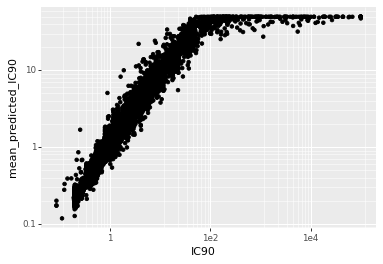

In [13]:
# NBVAL_IGNORE_OUTPUT

p = (
    ggplot(pred_ic90s)
    + aes("IC90", "mean_predicted_IC90")
    + geom_point()
    + scale_x_log10()
    + scale_y_log10()
)

_ = p.draw()

Predictions are fairly well correlated with actual values:

In [14]:
numpy.log(pred_ic90s[["IC90", "mean_predicted_IC90"]]).corr().round(2)

,IC90,mean_predicted_IC90
IC90,1.00,0.94
mean_predicted_IC90,0.94,1.00


They are better correlated if we look only at mutations seen in many variants:

In [15]:
numpy.log(
    bootstrap_poly.root_polyclonal.filter_variants_by_seen_muts(
        pred_ic90s,
        min_times_seen=20,
    )[["IC90", "mean_predicted_IC90"]]
).corr().round(2)

,IC90,mean_predicted_IC90
IC90,1.00,0.97
mean_predicted_IC90,0.97,1.00


We can also directly get the predicted probabilities of escape for variants at differenct concentration per bootstrap replicate:

In [16]:
# NBVAL_IGNORE_OUTPUT

bootstrap_poly.prob_escape_replicates(true_data, concentrations=[1, 4]).round(2).head()

,aa_substitutions,IC90,concentration,predicted_prob_escape,bootstrap_replicate
0,,0.11,1,0.00,1
1,A344E N370P A372P R408A V445A,10.90,1,0.54,1
2,A344E N394T I434V N481C P499S A520V,22.00,1,0.72,1
3,A344E N440G,0.55,1,0.06,1
4,A344E R346E,0.55,1,0.04,1


Or summarized across replicates:

In [17]:
# NBVAL_IGNORE_OUTPUT

pred_prob_escape = bootstrap_poly.prob_escape(true_data, concentrations=[1, 4])

pred_prob_escape.round(2).head()

,aa_substitutions,IC90,mean_predicted_prob_escape,median_predicted_prob_escape,std_predicted_prob_escape,n_models,frac_models
0,,0.11,0.00,0.00,0.00,10,2.0
1,A344E N370P A372P R408A V445A,10.90,0.36,0.35,0.17,10,2.0
2,A344E N394T I434V N481C P499S A520V,22.00,0.56,0.60,0.19,10,2.0
3,A344E N440G,0.55,0.02,0.01,0.02,10,2.0
4,A344E R346E,0.55,0.02,0.02,0.02,10,2.0
